# Libraries

In [162]:
# import csv
# import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [163]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample()

,title,url,year,text,tags,GPE,IND,ORG
478,"Trump, Greenland, Denmark. Is This Real Life?",https://www.nytimes.com/2019/08/21/opinion/tru...,2019,"Supported by\nTrump, Greenland, Denmark. Is Th...","[{'label': 'finances', 'score': '0.13378'}, {'...","[Trump, Greenland, Denmark, Greenland, Greenla...","[Peter, Trump, Helle Thorning-Schmidt, Trump, ...","[the Op-Ed, Greenlanders, The Wall Street Jour..."


## Cleaning

In [164]:
df = df[df['url'].apply(lambda x: 'www.nytimes.com/live/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/briefing/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/topic/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcast/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/dealbook/' not in x)]
df = df.reset_index(drop=True)




## Cleaning

In [165]:
total = 0

for index, row in df.iterrows():
           
    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    
    
    # gpe

    gpe = list(map(lambda x: x.replace(".", ""), gpe))
    gpe = list(map(lambda x: x.replace("’s", ""), gpe))
    gpe = list(map(lambda x: x.replace("The ", ""), gpe))
    gpe = list(map(lambda x: x.replace("the ", ""), gpe))

    # gpe = [a for a in gpe if (a == "Trump")]  # remove (do not work)
    # gpe = [a for a in gpe if ("Trumpanza" == a)]  # remove
    
    gpe = ['California' if 'Calif' in x else x for x in gpe]
    gpe = ['Florida' if 'Fla' in x else x for x in gpe]
    gpe = ['New York' if 'NY' in x else x for x in gpe]
    gpe = ['New Jersey' if 'NJ' in x else x for x in gpe]
    gpe = ['Washington' if 'WASHINGTON' in x else x for x in gpe]
    gpe = ['Baghdad' if 'BAGHDAD' in x else x for x in gpe]
    gpe = ['United States' if 'US' in x else x for x in gpe]
    gpe = ['Massachusetts' if 'Mass' in x else x for x in gpe]


    # individuals

    ind = list(map(lambda x: x.replace(".", ""), ind)) # remove dots
    ind = list(map(lambda x: re.sub(' [A-Z]* ', ' ', x), ind)) # remove middle initial
    
    ind = [a for a in ind if (" " in a)]  # remove ind without space
    ind = [a for a in ind if ("\n" not in a)]  # remove ind with \n

    ind = ['Bill De Blasio' if 'De Blasio' in x else x for x in ind]
    ind = ['Bill De Blasio' if 'de Blasio' in x else x for x in ind]

    ind = ['Mohammed bin Salman' if 'Crown Prince Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Crown Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Mohammed bin Salman' in x else x for x in ind]
    ind = ['Mohammed bin Salman' if 'Prince Mohammed' in x else x for x in ind]

    ind = ['Paul Mozur' if 'paul mozur' in x else x for x in ind]
    ind = ['Jane Coaston' if 'jane coaston' in x else x for x in ind]
    ind = ['Michael Barbaro' if 'michael barbaro' in x else x for x in ind]
    ind = ['Osama Bin Laden' if 'Bin Laden' in x else x for x in ind]
    
    
    # org

    org = list(map(lambda x: x.replace(".", ""), org))
    org = list(map(lambda x: x.replace("’s", ""), org))
    org = list(map(lambda x: x.replace("The ", ""), org))
    org = list(map(lambda x: x.replace("the ", ""), org))

    org = ['United States' if 'US' in x else x for x in org]
    org = ['United Nations' if 'UN' in x else x for x in org]
    org = ['United Nations' if 'un' in x else x for x in org]
    org = ['World Health Organization' if 'WHO' in x else x for x in org]
    org = ['National Security Agency' if 'NSA' in x else x for x in org]
    org = ['Food and Drugs Administration' if 'FDA' in x else x for x in org] 

    # org = [a for a in org if (a == "State")]  # remove (do not work)
    # org = [a for a in org if (a == "arch=Justice+Department's")]  # remove (do not work)


    # Save

    df.loc[index, "GPE"] = gpe
    df.loc[index, "IND"] = ind
    df.loc[index, "ORG"] = org

    # Total

    total += len(gpe) + len (ind) + len(org)

total

173680

## Set tags

In [166]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
79,The Real Wall Isn’t at the Border,https://www.nytimes.com/2019/01/26/opinion/sun...,2019,Supported by\nThe Real Wall Isn’t at the Borde...,"[United States, United States, Calais, France,...","[Nancy Pelosi, Muhammed Faris, Wendy Brown, At...","[Customs and Border Protection, United Nations...","[immigration and refugees, politics and govern..."


## Clean Years

In [167]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2017', '2016', '2012', '2010', '2018', '2011', '2023', '2014', '2021', '2022', '2020', '2015', '2019', '2013'}


## Entities

In [168]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    tag = row["TAG"]
    
    cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 34470


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
3,United States,gpe,7848,NaN,None,-1,-1,-1,"{'2010': 87, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ..."


# Treatment

## Normalization

In [169]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
23332,Aki Kaurismaki,ind,1,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2023/11/04/movies/hol...,"[Movies to See This Winter: ‘Hunger Games,’ ‘M...","[ORLANDO, Orlando, Zhili, China, Hulu, Washing...",0.0,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Filter

In [170]:
# Number of rows by type

# max_gpe = 100
# max_ind = 0
# max_org = 0
# max_tag = 0

# top_gpe = (
#     entities_all.loc[entities_all["type"] == "gpe"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_gpe)
# )
# top_ind = (
#     entities_all.loc[entities_all["type"] == "ind"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_ind)
# )
# top_org = (
#     entities_all.loc[entities_all["type"] == "org"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_org)
# )
# top_tag = (
#     entities_all.loc[entities_all["type"] == "tag"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_tag)
# )

# entities = pd.concat([top_gpe, top_ind, top_org, top_tag])



min_frequency = 50

entities = (
    entities_all[entities_all['frequency']>min_frequency]
    .sort_values(by=["frequency"], ascending=False)
)

len(entities)

344

In [171]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3,United States,gpe,7848,NaN,None,-1,-1,-1,"{'2010': 87, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",1.000000,"{""2010"": 87, ""2011"": 87, ""2012"": 90, ""2013"": 4..."
0,China,gpe,6198,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",0.789729,"{""2010"": 47, ""2011"": 4, ""2012"": 58, ""2013"": 15..."
835,Russia,gpe,2526,NaN,None,-1,-1,-1,"{'2010': 28, '2011': 4, '2012': 4, '2013': 88,...",[https://www.nytimes.com/2018/12/28/us/politic...,[Departing House Republicans Try to Keep Inves...,"[Washington, Virginia, South Carolina, Russia,...",0.321779,"{""2010"": 28, ""2011"": 4, ""2012"": 4, ""2013"": 88,..."


## Linear Regression

In [172]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
364,North Korea,gpe,267,-1.239806,None,-1,-1,-1,"{'2010': 1, '2011': 12, '2012': 1, '2013': 9, ...",[https://www.nytimes.com/aponline/2018/12/10/w...,[The Latest: Huawei Expects 'Just Conclusion' ...,"[VANCOUVER, British Columbia, Canada, China, U...",0.033898,"{""2010"": 1, ""2011"": 12, ""2012"": 1, ""2013"": 9, ..."


## Colors

In [173]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3,United States,gpe,7848,106.793161,#b40426,-1,-1,-1,"{'2010': 87, '2011': 87, '2012': 90, '2013': 4...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",1.0,"{""2010"": 87, ""2011"": 87, ""2012"": 90, ""2013"": 4..."


# Embedding

## Term Frequency

In [174]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

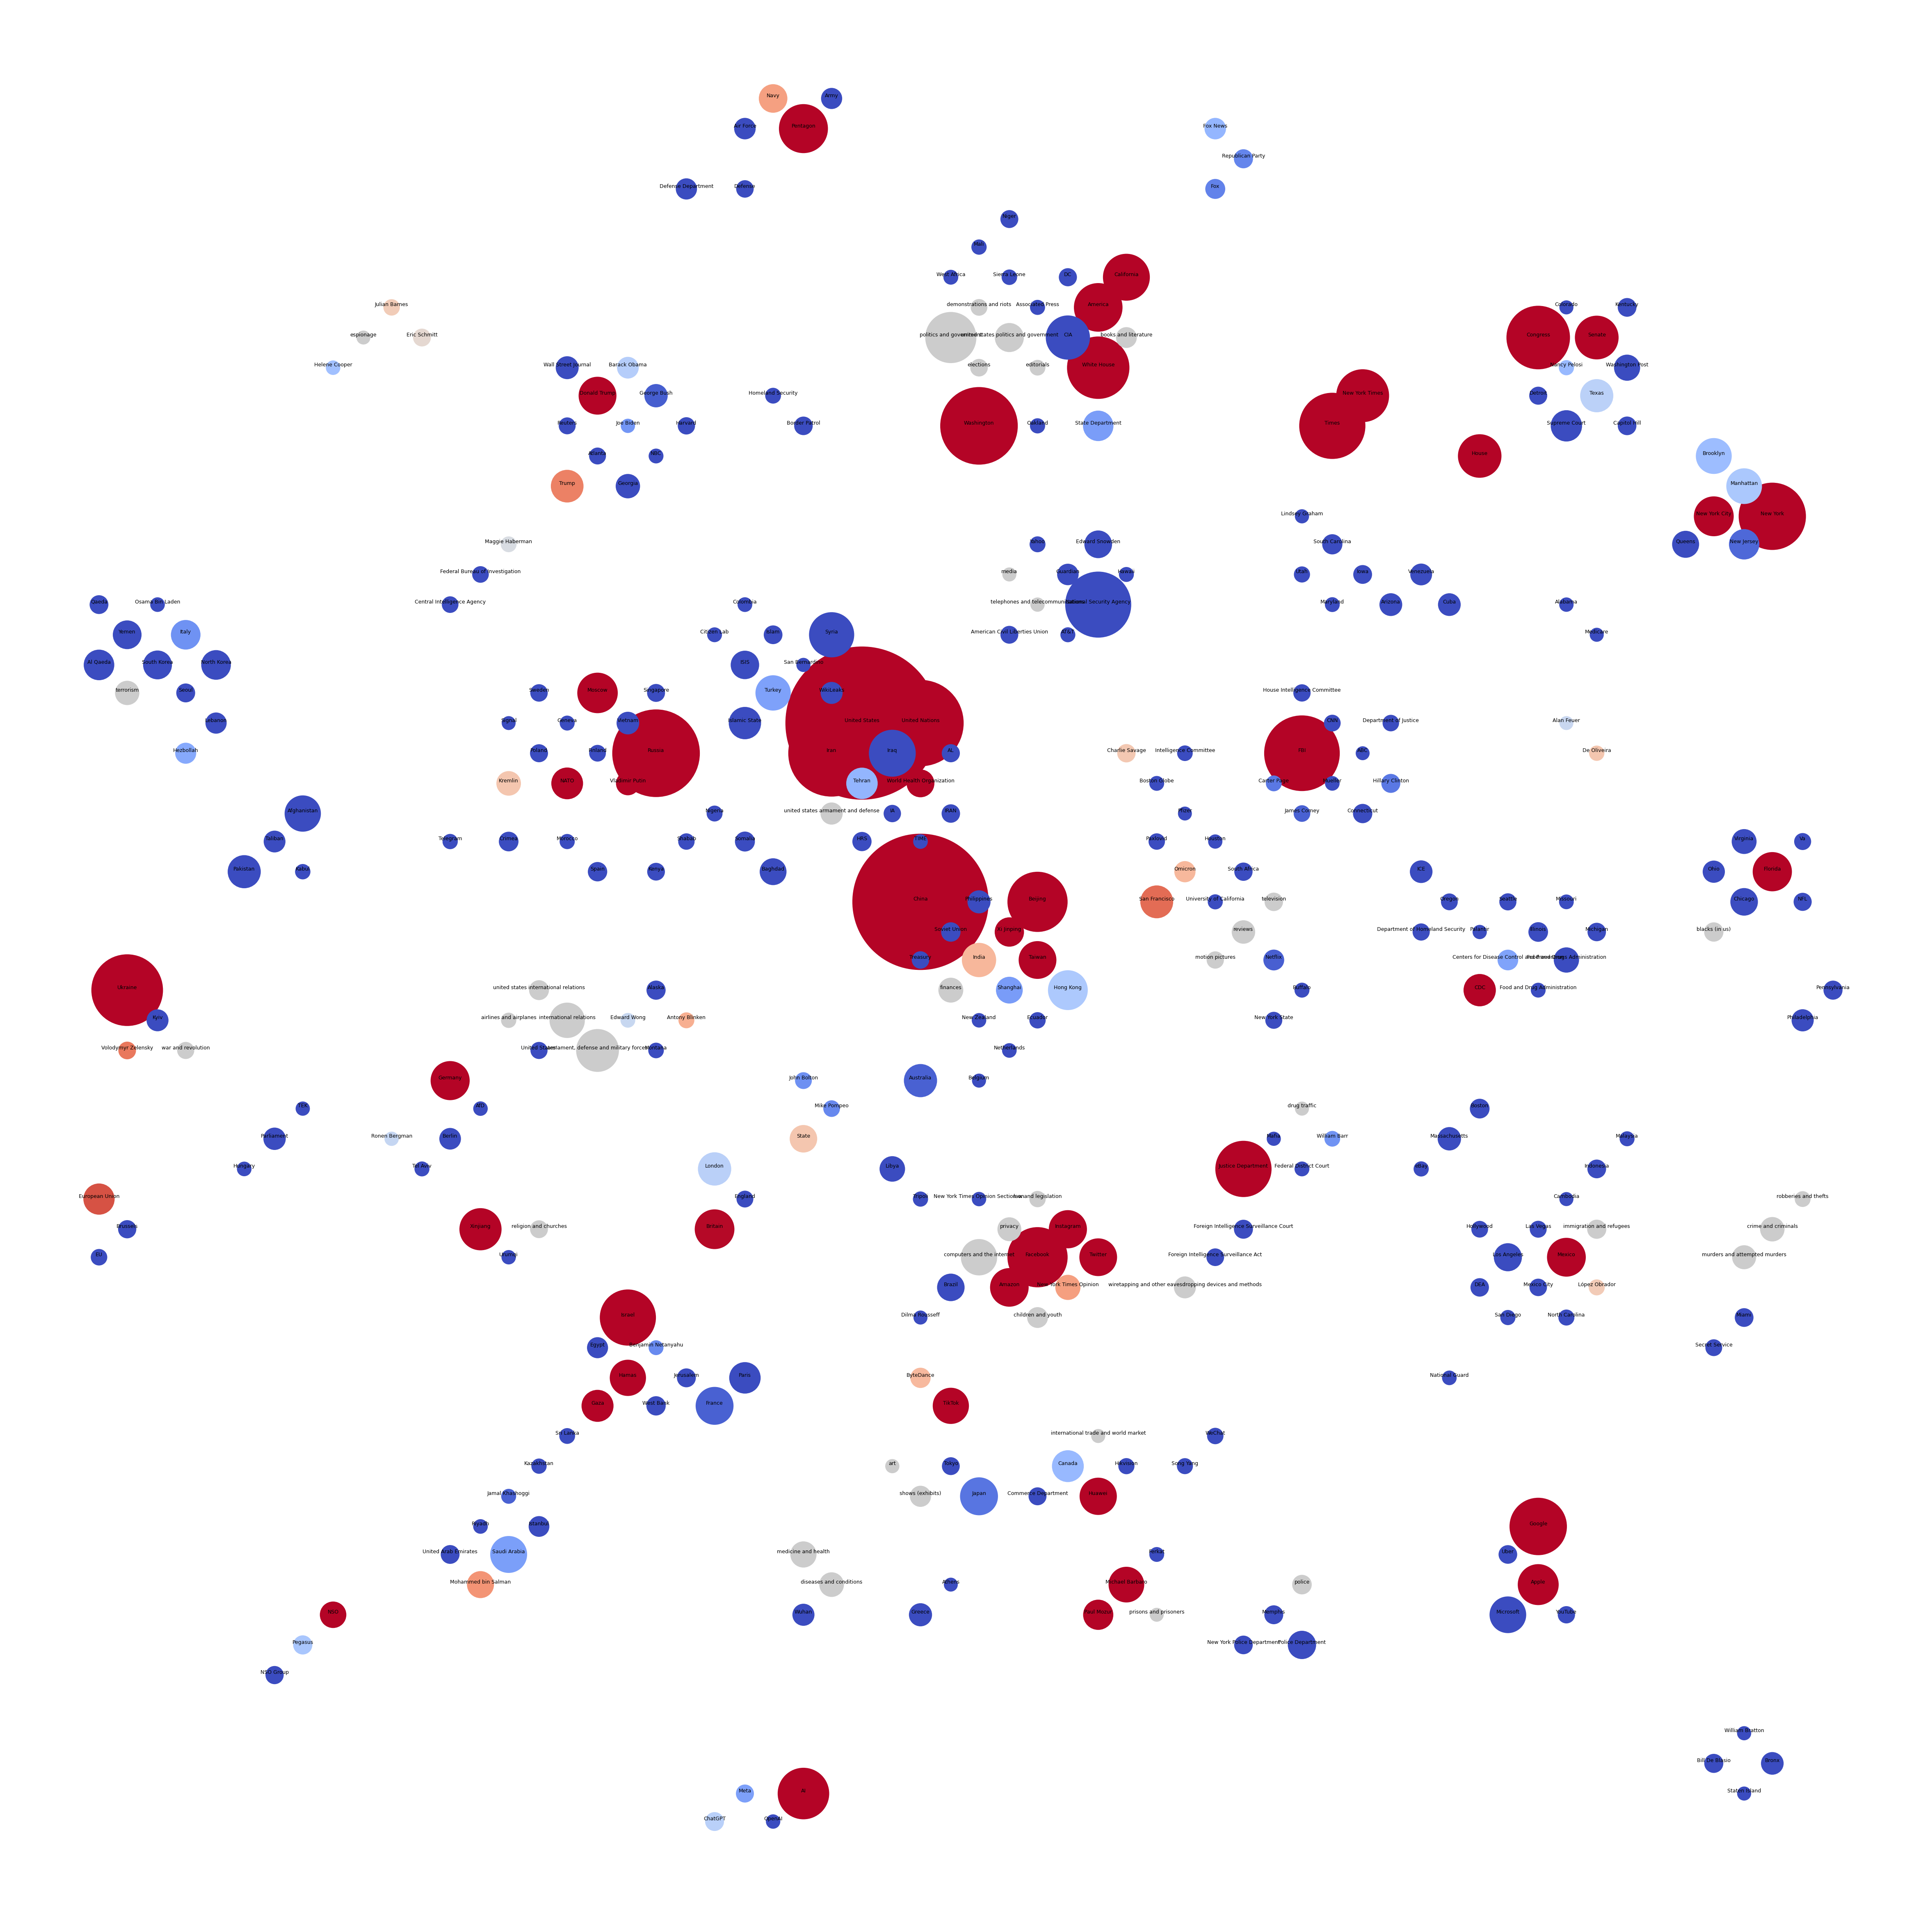

In [175]:
reducer = umap.UMAP(
    random_state=2,
    n_components=2,
    n_neighbors=2,
    min_dist=0.3,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [176]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1512,Hawaii,gpe,60,-4.428817,#3b4cc0,574,679,n_7,"{'2010': 2, '2011': 1, '2012': 0, '2013': 19, ...",[https://www.nytimes.com/2019/01/08/us/politic...,[Trump’s Speech to the Nation: Fact Checks and...,"[United States, America, United States, United...",0.007519,"{""2010"": 2, ""2011"": 1, ""2012"": 0, ""2013"": 19, ..."


{'-1', 'n_2', 'n_24', 'n_22', 'n_19', 'p_5', 'n_16', 'n_0', 'p_6', 'n_17', 'n_7', 'n_21', 'n_11', 'p_8', 'n_9', 'n_3', 'p_2', 'p_0', 'p_4', 'n_4', 'n_23', 'n_12', 'n_20', 'n_14', 'p_7', 'n_6', 'n_25', 'n_8', 'n_10', 'n_15', 'n_5', 'n_1', 'p_3', 'p_1', 'n_13', 'n_18'}
83
4
8
10
7
4
12
4
5
11
9
3
7
7
6
13
4
6
5
13
6
6
8
10
5
11
7
12
11
5
4
4
11
8
9
6


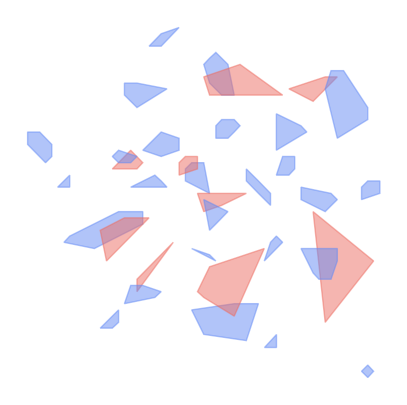

In [177]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [178]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
848,James Comey,ind,76,-0.90199,#4961d2,655,568,n_19,[https://www.nytimes.com/2018/12/28/us/politic...,0.009558,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."
